In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
G=nx.Graph()

In [3]:
linelist,e,no=[],[],[]
with open ("In-class_network.txt","r") as F :
    for line in F :
        line=line.replace("\t",".").strip("\n").split(".")
        linelist.append(line)
    linelist=linelist[1:]
    for i in range(len(linelist)):
        linelist[i]=linelist[i][0:2]
        linelist[i][0]=int(linelist[i][0])
    for i in range(len(linelist)):
        if linelist[i][1].count(",")>=1:
            num=linelist[i][1].split(",")
            for d in num :
                e+=[(linelist[i][0],int(d))]
        elif linelist[i][1]==" ":
            no+=[linelist[i][0]]
        else :
            e+=[(linelist[i][0],int(linelist[i][1]))]

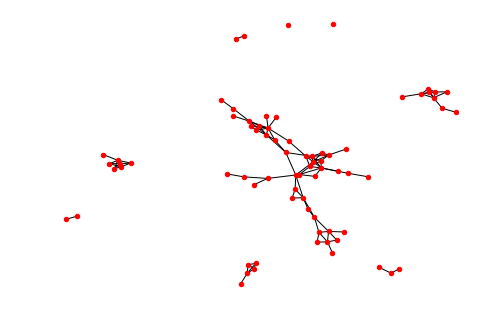

In [4]:
G.add_nodes_from(no)
G.add_edges_from(e)
nx.draw(G,node_size=20)
plt.show()

In [5]:
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 75\nNumber of edges: 109\nAverage degree:   2.9067'

In [6]:
apl,n=0,0
for i in nx.connected_components(G):
    apl+=nx.average_shortest_path_length(nx.subgraph(G,i))
    n+=1
apl=float(apl/n)
apl

1.3965367965367967

In [7]:
nG=len(list(nx.connected_components(G))[0])
for i in list(nx.connected_components(G))[1:]:
    if len(i)>nG :
        nG=len(i)
nG

45

In [8]:
emax=G.order()*(G.order()-1)/2
print(G.size()/emax)

0.03927927927927928


[1, 1, 5, 3, 6, 4, 5, 6, 2, 9, 2, 2, 5, 5, 1, 4, 1, 3, 5, 4, 4, 1, 1, 1, 6, 5, 0, 2, 1, 1, 2, 3, 1, 5, 1, 4, 1, 4, 5, 4, 1, 4, 1, 3, 2, 2, 2, 4, 3, 5, 1, 4, 1, 3, 1, 1, 4, 1, 2, 1, 1, 2, 2, 3, 4, 2, 4, 4, 3, 5, 8, 3, 2, 3, 0]


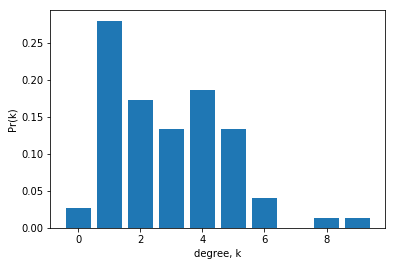

In [18]:
def deg(G):
    vector,degree=[],[]
    for i in G.nodes():
        vector+=[i]
        degree+=[len(G.edges(i))]
    ki=pd.DataFrame({"vector":vector,"degree":degree})
    ki=ki.sort_values(by="vector")
    vector_k,x,y=[],[],[]
    ki2=ki["degree"].value_counts().sort_index()    
    vector_k+=list(ki["degree"])
    for i in ki2.index:
        x+=[i]
        y+=[ki2[i]/G.order()]
    return(vector_k,x,y)
vector_k,x,y=deg(G)
print(vector_k)
plt.bar(x,y)
plt.xlabel("degree, k")
plt.ylabel("Pr(k)")
plt.show()

In [10]:
def triangle(G):
    tri=[]
    for i in nx.connected_components(G):
        if len(i)>=3:
            for j in i :
                num=()
                for g in G.edges(j): 
                    for z in G.edges(g[1]):
                        if z[1]!=j:  
                            for c in G.edges(z[1]): 
                                if c[1]==j:
                                    num=tuple(sorted([g[0],g[1],z[1]]))
                                    tri+=[num]
    tri=len(set(tri))
    return tri
tri=triangle(G)
print(tri)

52
